In [4]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles,smiles_to_mol
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
from rdkit.Chem import Draw
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess


In [ ]:
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn']

In [40]:
from evaluation.moses.metrics import get_all_metrics
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['nn', 'structural','molecular', 'auc_roc']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn'] 
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            generated_graphs, generated_targets,smiles=get_generated_data(dataset_name+split, generator_name=generator,return_smiles=True)
            mol_metrics=get_all_metrics(gen=smiles,train=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

hiervae ames _25 {'valid': 1.0, 'unique@1000': 0.145, 'unique@10000': 0.13825608798114689, 'FCD/Test': 43.47548892368003, 'SNN/Test': 0.15007773061624588, 'Frag/Test': 0.009695998610825929, 'Scaf/Test': 0.0, 'FCD/TestSF': 44.253330897273266, 'SNN/TestSF': 0.139073268565271, 'Frag/TestSF': 0.012055070082587216, 'Scaf/TestSF': 5.129849552776289e-05, 'IntDiv': 0.9134372697936957, 'IntDiv2': 0.8022391734161626, 'Filters': 0.5899450117831894, 'logP': 2.2038268944554678, 'SA': 1.4214461277888697, 'QED': 0.42440619497343984, 'weight': 250.16577883826636, 'Novelty': 0.9602272727272727}
hiervae ames _33 {'valid': 1.0, 'unique@1000': 0.283, 'unique@10000': 0.21908127208480566, 'FCD/Test': 42.53675621453302, 'SNN/Test': 0.17748508471842017, 'Frag/Test': 0.05105189489946671, 'Scaf/Test': 2.638943320099063e-05, 'FCD/TestSF': 43.471522712876336, 'SNN/TestSF': 0.16034279524340997, 'Frag/TestSF': 0.06773024861213228, 'Scaf/TestSF': 1.1536177293436367e-05, 'IntDiv': 0.8881725070117816, 'IntDiv2': 0.798

In [41]:
from evaluation.moses.metrics import get_all_metrics

for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            generated_graphs, generated_targets=smiles1['train1_smiles'],train1_targets
            mol_metrics=get_all_metrics(gen=generated_graphs,train=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train1 ames _25 {'valid': 1.0, 'unique@1000': 0.999, 'unique@10000': 0.9992144540455616, 'FCD/Test': 21.781775291678983, 'SNN/Test': 0.3460786905072378, 'Frag/Test': 0.609096242342599, 'Scaf/Test': 0.07181614456792074, 'FCD/TestSF': 22.86709712525912, 'SNN/TestSF': 0.3347151500742827, 'Frag/TestSF': -0.007764708095505224, 'Scaf/TestSF': 0.15573039734059768, 'IntDiv': 0.9115402626448194, 'IntDiv2': 0.8910555622455708, 'Filters': 0.5648075412411626, 'logP': 0.8414846782538974, 'SA': 0.39479570823158266, 'QED': 0.3020678291821059, 'weight': 92.34040517884273, 'Novelty': 0.0007861635220125787}
train1 ames _33 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 1.0, 'FCD/Test': 21.236416889626646, 'SNN/Test': 0.34834962803760744, 'Frag/Test': 0.5781554686180765, 'Scaf/Test': 0.07074550219218434, 'FCD/TestSF': 22.32740778317273, 'SNN/TestSF': 0.33650527514069745, 'Frag/TestSF': -0.0564585395413002, 'Scaf/TestSF': 0.17318521765311345, 'IntDiv': 0.9104997850215626, 'IntDiv2': 0.8916725499146103

In [42]:
from evaluation.moses.metrics import get_all_metrics

for generator in ['train2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            train2_pos_smiles=smiles1['train2_pos_smiles']
            train2_neg_smiles=smiles1['train2_neg_smiles']
            train2_graphs=train2_pos_smiles+train2_neg_smiles
            #train2_targets = np.array([1]*len(train2_pos_smiles) + [0]*len(train2_neg_smiles))
            generated_graphs=train2_graphs
            mol_metrics=get_all_metrics(gen=generated_graphs,train=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train2 ames _25 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 0.9989531536247056, 'FCD/Test': 20.925845530401126, 'SNN/Test': 0.35017161944077235, 'Frag/Test': 0.5775453373518646, 'Scaf/Test': 0.09539052990468633, 'FCD/TestSF': 22.029602836827685, 'SNN/TestSF': 0.33657932424812037, 'Frag/TestSF': -0.059282118951847984, 'Scaf/TestSF': 0.1758219187605672, 'IntDiv': 0.9099865986374363, 'IntDiv2': 0.8923639507448167, 'Filters': 0.5563988484689871, 'logP': 0.8422316026494058, 'SA': 0.39152390062767095, 'QED': 0.29595233176938956, 'weight': 90.33570975871515, 'Novelty': 0.9986900707361802}
train2 ames _33 {'valid': 1.0, 'unique@1000': 0.997, 'unique@10000': 0.998527679623086, 'FCD/Test': 21.070158683236308, 'SNN/Test': 0.34954836940254636, 'Frag/Test': 0.5906718037471668, 'Scaf/Test': 0.09921941810851997, 'FCD/TestSF': 22.174546107895935, 'SNN/TestSF': 0.3359175579528049, 'Frag/TestSF': -0.03894815366497717, 'Scaf/TestSF': 0.17036759946248248, 'IntDiv': 0.9102878601909401, 'IntDiv2': 0.

In [46]:
from evaluation.moses.metrics import get_all_metrics
from sklearn.utils import shuffle 
for generator in ['train1/2+train2/2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            #print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            train2_pos_smiles=smiles1['train2_pos_smiles']
            train2_neg_smiles=smiles1['train2_neg_smiles']
            train2_graphs=shuffle(train2_pos_smiles+train2_neg_smiles)
            train2_targets = np.array([1]*len(train2_pos_smiles) + [0]*len(train2_neg_smiles))
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs=list(smiles1['train1_smiles'][:half]+train2_graphs[:half])
            generated_graphs=train3_graphs
            mol_metrics=get_all_metrics(gen=generated_graphs,train=smiles1['train1_smiles'],test=list(smiles1['train1_smiles']))
            print(generator,dataset_name,split,mol_metrics)

train1/2+train2/2 ames _25 {'valid': 1.0, 'unique@1000': 1.0, 'unique@10000': 1.0, 'FCD/Test': 0.7904572060235608, 'SNN/Test': 0.7514531218194924, 'Frag/Test': 0.9874218010905594, 'Scaf/Test': 0.8838672479875699, 'FCD/TestSF': 22.556825322699517, 'SNN/TestSF': 0.33532934654035473, 'Frag/TestSF': -0.025246925807700826, 'Scaf/TestSF': 0.16665821905137568, 'IntDiv': 0.910043830533207, 'IntDiv2': 0.8899929747197383, 'Filters': 0.5621069182389937, 'logP': 0.07561705939641397, 'SA': 0.029469839338340794, 'QED': 0.008785631679633997, 'weight': 2.092928590661392, 'Novelty': 0.5007861635220126}


KeyboardInterrupt: 

In [6]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['nn', 'structural','molecular', 'auc_roc']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn']

In [ ]:
from sklearn.utils import shuffle
#draw generated data
dataset_name='ames'
split='_25'
generator_name='wgan'
collected_molecules=[]
for dataset_name in ['cyp1a2_veith']:
    for split in ['_33']:
        #(train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles =get_data(dataset_name+split, return_smiles=True)
        generated_graphs, generated_targets,smiles=get_generated_data(dataset_name+split, generator_name=generator_name,return_smiles=True)
        #draw_graphs(generated_graphs[12:18],num_per_line=8)
        #print(f'Generated by {generator_name} from {dataset_name+split}')
        collected_molecules=collected_molecules+smiles_to_mol(shuffle(smiles))
Draw.MolsToGridImage(collected_molecules,molsPerRow=5
                     )

In [ ]:
Draw.MolsToGridImage(collected_molecules,molsPerRow=8
                     )

In [13]:
import pandas as pd
test=pd.read_csv('out.csv')

In [14]:
only_25=test.loc[(test.dataset=='ames_50') | (test.dataset=='bbb_martins_50') | \
                      (test.dataset=='herg_karim_50') | (test.dataset=='cyp1a2_veith_50') \
                        | (test.dataset=='cyp2c19_veith_50')| \
                       (test.dataset=='lipophilicity_astrazeneca_50')   ]

Text(0.5, 1.0, 'Molecular Weight')

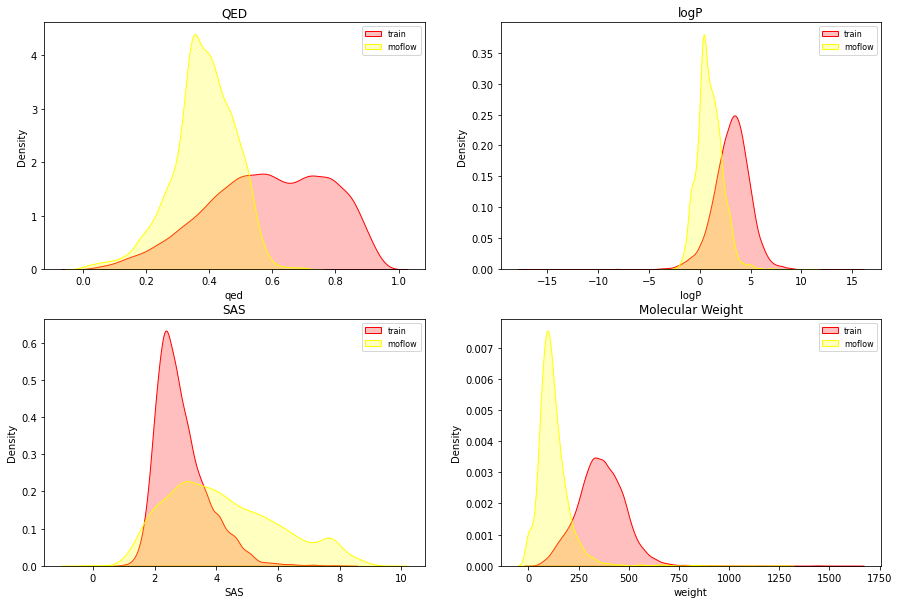

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore") 
 
generator_name='moflow'
fig,ax=plt.subplots(2,2,figsize=(15, 10))

sns.kdeplot(only_25[only_25.generator=='original']['qed'], color="red", shade=True,ax=ax[0,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['qed'], color="yellow", shade=True,ax=ax[0,0])
#sns.kdeplot(only_25[only_25.generator=='jtnn']['qed'], color="teal", shade=True,ax=ax[0,0])


ax[0,0].legend(labels=['train',generator_name],fontsize=8)
ax[0,0].set_title('QED')



sns.kdeplot(only_25[only_25.generator=='original']['logP'], color="red", shade=True,ax=ax[0,1])
sns.kdeplot(only_25[only_25.generator==generator_name]['logP'], color="yellow", shade=True,ax=ax[0,1])
ax[0,1].legend(labels=['train',generator_name],fontsize=8)
ax[0,1].set_title('logP')


sns.kdeplot(only_25[only_25.generator=='original']['SAS'], color="red", shade=True,ax=ax[1,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['SAS'], color="yellow", shade=True,ax=ax[1,0])
ax[1,0].legend(labels=['train',generator_name],fontsize=8)
ax[1,0].set_title('SAS')


sns.kdeplot(only_25[only_25.generator=='original']['weight'], color="red", shade=True,ax=ax[1,1])

sns.kdeplot(only_25[only_25.generator==generator_name]['weight'], color="yellow", shade=True,ax=ax[1,1])

ax[1,1].legend(labels=['train',generator_name],fontsize=8)
ax[1,1].set_title('Molecular Weight')


In [24]:
list=[1,2,3,4]
list[:4]


[1, 2, 3, 4]